In [1]:
%run "./utils.ipynb"

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='SE'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = True

LOAD_OLD_DATA_TRAIN = False
LOAD_OLD_DATA_TEST = False
MERGE_TESTS=True

TEST_CLASS_CAP =999999

pre_Process_remove_empties = True


# per Karthika's change
SKIP_LOCK_FILE = True

In [3]:
def print_info(y_test, pred , classes , confidance=0.5, print_skf1=False, size= 500):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
      
    
    unknonw_index =-1

    tp = 0.00000001
    tn = 0.00000001
    fp =0.00000001
    fn = 0.00000001
    
    for index in range(len(classes)):
        if 'unknown' in classes[index]:
            unknonw_index = index
            continue
            
        tp += conf[index][1][1]
        tn += conf[index][0][0]
        fp += conf[index][0][1] 
        fn += conf[index][1][0]
        
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    knowns_accs= [acc, recall, prec, F]
    print ("------------------------------------------------------------------------")
    index = unknonw_index
    tp += conf[index][1][1]
    tn += conf[index][0][0]
    fp += conf[index][0][1] 
    fn += conf[index][1][0]

    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
 
    all_accs =  [acc, recall, prec, F]
 
  
    return size, all_accs, knowns_accs

In [4]:
from ipywidgets import IntProgress
from IPython.display import display
pbar = IntProgress(min=0, max=len(range(50, 26000, 200)))  
display(pbar) 

IntProgress(value=0, max=130)

In [5]:
count_eval_results = []

x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = []
y_train = []
y_train_service = []

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    if LOAD_OLD_DATA_TRAIN:
        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
            y_data = json.load(f)

        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
            x_data = json.load(f)

#             if len( y_data ) != len(x_data) :
#                 print( pick )


        x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    else:

        for pick in sorted(glob.glob( '../files/iot_data_2020/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)

            with open( os.path.join( '../files/iot_data_2020/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/iot_data_2020/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
#                     print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )

            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)


#         print("loading from test files")
    files_path =  '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/*.json'
    test_y_dir = '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/'  if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/hub_segments_final/'
    test_x_dir = '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/'

    test_files = [ x for x in sorted(glob.glob(files_path)) if not SKIP_LOCK_FILE or ( SKIP_LOCK_FILE and  'lock' not in x )]
#         print( "found files : " , len(test_files) )


    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
#             print(pick)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )


        if MERGE_TESTS:
            x_test.extend(t_x)
            y_test.extend(t_y)
            y_test_service.extend(t_z)
        else:
            x_test.append(t_x)
            y_test.append(t_y)
            y_test_service.append(t_z)
if MERGE_TESTS:
    x_test = [x_test]
    y_test = [y_test]
    y_test_service = [y_test_service]
    test_names =['MERGED']

x_train_all = x_train
y_train_all = y_train

for t_len in range(50, 26000, 200):
    

    x_train = x_train_all[:t_len]
    y_train = y_train_all[:t_len]

    classes = sorted(list(np.unique(  np.concatenate( y_train  ))))


    if Mapper=='SE':
        services_to_keep = ['button-held',
     'button-pushed',
            "colorTemperature-XXX",
    "contact-closed",
    "contact-open",
    "level-XXX",
    "lock-locked",
    "lock-unlocked",
    "motion-active",
    "motion-inactive",
    "ping-ping",
    "status-closed",
    "status-open",
    "switch-off",
    "switch-on",
    "temperature-XXX"
        ] 
    else:
         services_to_keep =["button",
    "colorTemperature",
    "contact",
    "level",
    "lock",
    "motion",
    "ping",
    "status",
    "switch",
    "temperature"]


    train_indexes_to_change =  [ i for i in range(len(y_train)) if
                  is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

    y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
               for i in range(len(y_train)) ] 

    for t_index in range(len(y_test)):
        test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                      is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

        y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
                   for i in range(len(y_test[t_index])) ] 

    def make_known_unknown(inp, unknown_ind):
        return [ [1,0] if (x[unknown_ind] == 1 ) else [0,1]   for x in inp ]

    known_unknown_y_train = [ [1,0] if (len(x) == 1 and ("unknown" in x or 'unknown-' in x)) else [0,1]   for x in y_train ]

    known_unknown_y_test= [] 

    for i in range(len(y_test)):

        known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


    classes = services_to_keep
    classes.append('unknown')


    _,_,temp = pre_process_raw( x_test[0], y_test[0] , 13, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP,remove_empty=True)
    indexes_to_keep = temp[1]


    dim_size= 20
    x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True,remove_empty=pre_Process_remove_empties)
    rf_test = [] 

    rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 

    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
    x_xgb_train = vectorizer.fit_transform(x_random_forest_train)
    xgb_test = []
    for x in range(len(rf_tests)):
        xgb_test.append( ( vectorizer.transform(rf_tests[x][0]),
                        rf_tests[x][1],
                        rf_tests[x][2]
                      ))
    

    from sklearn.ensemble import RandomForestClassifier

    knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                                 random_state=0 )
    knownity_rf_results = knownity_rf.fit(x_xgb_train, known_unknown_y_train)


    train_known_unknown_pred=knownity_rf.predict(x_xgb_train)

    test_known_unknown_predicted = []
    for i in range(len(rf_tests)) :
     
        rf_pred=knownity_rf.predict( xgb_test[i][0])
        test_known_unknown_predicted.append(rf_pred)
        print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

    known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

    x_train_known = x_xgb_train[known_indexes_train]
    y_train_known = y_random_forest_train[known_indexes_train]

    rf_test_known = [] 

    for test_index in range(len(test_known_unknown_predicted)):
        known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]

        rf_test_known.append(  (xgb_test[test_index][0][known_indexes], 
                                rf_tests[test_index][1][known_indexes],
                                rf_tests[test_index][2],
                                known_indexes
                               ))

    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                                 random_state=0 )
    t_hist = clf.fit(x_train_known, y_train_known)


    rf_results = []
    rf_preds = [] 
    for i in range(len(rf_test_known)) :

        rf_pred= clf.predict( rf_test_known[i][0])
        rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
        rf_preds.append(rf_pred)
        count_eval_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.09))
    pbar.value += 1

in load from merged
2522 2335
0 0
7 6
0 0
9 9
3161 3047
2703 2229
17 17
29 17
2960 2778
1775 1697
15 12
191 143
0 0
10 9
7114 6606
983 652
918 890
1703 1540
7 7
2199 2179
18308 18308
5837 5837
233 233
8133 8133
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [17]:
rng =  range(50, 26000, 200)
count_eval_results_new = [] 
for i,x in enumerate(count_eval_results):
    count_eval_results_new.append((rng[i], count_eval_results[i][1], count_eval_results[i][2]) ) 
# count_eval_results_new[:50]
count_eval_results = count_eval_results_new

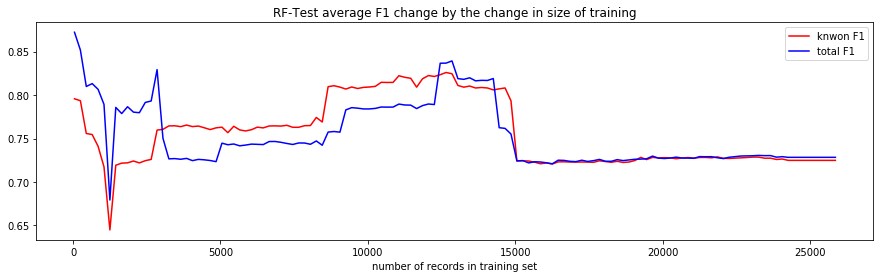

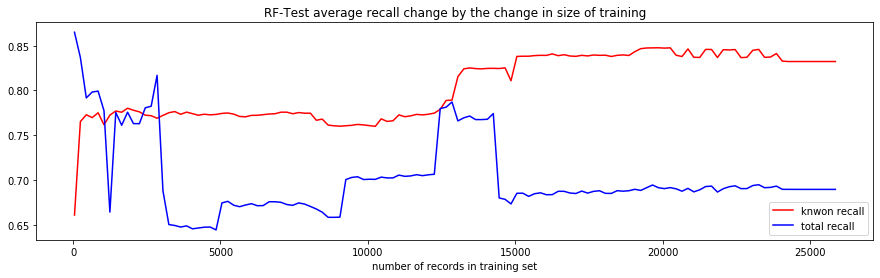

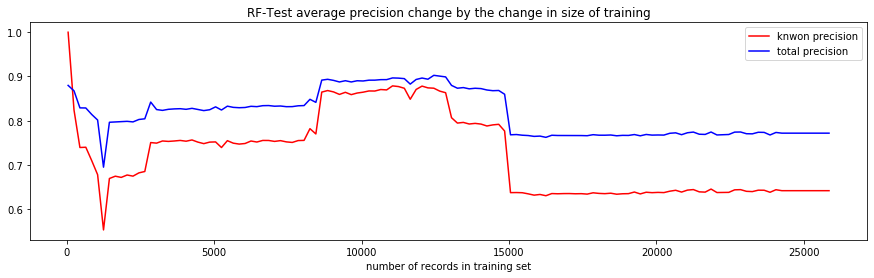

In [18]:

counts = [x[0] for x in count_eval_results]
known_f1 = [x[2][-1] for x in count_eval_results]
all_f1 = [x[1][-1] for x in count_eval_results]

known_recall = [x[2][1] for x in count_eval_results]
all_recall = [x[1][1] for x in count_eval_results]

known_pres = [x[2][-2] for x in count_eval_results]
all_pres = [x[1][-2] for x in count_eval_results]

plt.figure(figsize=(15,4))
plt.title('RF-Test average F1 change by the change in size of training')
plt.xlabel('number of records in training set')
plt.plot(counts, known_f1, c='red',  label='knwon F1')
plt.plot(counts, all_f1, c='blue',  label='total F1')

plt.legend()

plt.figure(figsize=(15,4))
plt.title('RF-Test average recall change by the change in size of training')
plt.xlabel('number of records in training set')

plt.plot(counts, known_recall, c='red',  label='knwon recall')
plt.plot(counts, all_recall, c='blue',  label='total recall')

plt.legend()

plt.figure(figsize=(15,4))
plt.title('RF-Test average precision change by the change in size of training')
plt.xlabel('number of records in training set')

plt.plot(counts, known_pres, c='red',  label='knwon precision')
plt.plot(counts, all_pres, c='blue',  label='total precision')

plt.legend()

In [19]:
def flatter(inp):
    ret = [inp[0]]
    ret.extend(inp[1])
    ret.extend(inp[2])
    
    return ret

csv_ready = [flatter(x) for x in count_eval_results]

    
import csv 

with open('./outputs/rf_training_by_row_evaluation.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['#training','acc','recall','precision','f1','known_acc','knwon_recall', 'known_precision','known_f1'])
    writer.writerows(csv_ready)

In [8]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
